## Realizar el Acceso a Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Instalación y Carga de Librerías para la actividad

**Instalación de Implicit**

In [ ]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1MB 2.9MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419442 sha256=cb337d77f4aca4dcaeb7b5e97781048656d246cbda94ceb35aeb95a8d48b7724
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


**Carga de paqueteria necesaria**

In [ ]:
import csv
import implicit
import matplotlib.pyplot as plt
import random
import json
#import tensorflow as tf
import random, string
import pickle
import seaborn as sns
from time import time #importamos la función time para capturar tiempos
%matplotlib inline
sns.set(style="whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
OPENBLAS_NUM_THREADS=1

In [ ]:
import numpy as np
import pandas as pd
from math import ceil
from tqdm import trange
from subprocess import call
from scipy.sparse import csr_matrix, dok_matrix

In [ ]:
from time import time
def count_elapsed_time(f):
    """
    Decorator.
    Execute the function and calculate the elapsed time.
    Print the result to the standard output.
    """
    def wrapper():
        # Start counting.
        start_time = time()
        # Take the original function's return value.
        ret = f()
        # Calculate the elapsed time.
        elapsed_time = time() - start_time
        print("Elapsed time: %0.10f seconds." % elapsed_time)
        return ret
    
    return wrapper

# **Resnet**

## Carga de los embeddings Resnet50

In [ ]:
df_item1=np.load('/content/drive/My Drive/Tarea_SR/data/resnet50_embeddings.npy', allow_pickle=True)

In [ ]:
print(df_item1)

[['b603f445fc6f72d89b7dcba38fbb3a72'
  array([0.37427816, 1.0223378 , 0.05951078, ..., 0.18718696, 0.512178  ,
       0.19899085], dtype=float32)]
 ['a5c93f071a28ef5b7503218835106266'
  array([0.1860372 , 0.6666795 , 0.28292888, ..., 0.46189007, 1.3665308 ,
       0.1318419 ], dtype=float32)]
 ['910df50522b97ee5661bc75b5e997226'
  array([0.15570807, 0.5350622 , 1.4801795 , ..., 0.10824655, 0.2820762 ,
       0.4309257 ], dtype=float32)]
 ...
 ['ca7f333886e56a1a95f775bbbeb14a74'
  array([0.13141339, 2.2440066 , 0.13448334, ..., 0.5081015 , 0.31848136,
       0.23972231], dtype=float32)]
 ['1e5b06bb1fdc96013251d007c96cec55'
  array([2.1561399 , 1.3555701 , 1.2488506 , ..., 0.18485127, 0.63357466,
       1.962909  ], dtype=float32)]
 ['212972e36e7059ee3d3dda65f3fb715c'
  array([0.65191853, 0.354235  , 0.3253313 , ..., 0.12209289, 0.09699631,
       0.516472  ], dtype=float32)]]


## Selección embeddings

In [ ]:
df_itemEMbeddings=pd.DataFrame.from_records(df_item1, columns =['item_id', 'embedding']) 

In [ ]:
print(df_itemEMbeddings.iloc[: , 1])
prueba=df_itemEMbeddings.iloc[: , 1]

0        [0.37427816, 1.0223378, 0.05951078, 0.53245056...
1        [0.1860372, 0.6666795, 0.28292888, 0.6218527, ...
2        [0.15570807, 0.5350622, 1.4801795, 0.16154194,...
3        [0.060747527, 0.61796606, 0.42335093, 0.161621...
4        [0.19465646, 0.29358056, 0.64005965, 0.2761311...
                               ...                        
71022    [0.014733706, 0.20050731, 0.040910818, 0.80886...
71023    [0.16452798, 0.4965312, 0.19549541, 0.01773245...
71024    [0.13141339, 2.2440066, 0.13448334, 0.06848573...
71025    [2.1561399, 1.3555701, 1.2488506, 0.5615909, 0...
71026    [0.65191853, 0.354235, 0.3253313, 0.18456644, ...
Name: embedding, Length: 71027, dtype: object


# **Creacion de dataframe con los datos**

## Dataset para Entrenamiento y Testing

In [ ]:
# Primero creamos el dataframe con los datos
url = '/content/drive/My Drive/Tarea_SR/data/train1.csv'
df = pd.read_csv(url  ,
                         sep=',',
                        index_col=None,
                         names=['user_id', 'item_id', 'rating', 'timestamp'],
                         header=0
                  )

print('data dimension: \n', df.shape)
#df.head()

data dimension: 
 (78023, 4)


In [ ]:
df.head()

,user_id,item_id,rating,timestamp
0,0,e29e422c743a3d39a45c2bf777cc7091,1,1447833945
1,1,c0cefffdc4f2cb23c01fdd0257ffc82d,1,1447931155
2,2,77a5bb1f382cfa168f53e870bf7dc96b,1,1447867326
3,3,a0d92aa0cc44c61ac2c2592e6ed702d2,1,1447876751
4,4,664c68013188241c5ad641830e09c55f,1,1447890664


In [ ]:
def create_matrix(data, user_col, item_col, rating_col):
    """
    creates the sparse user-item interaction matrix
    
    Parameters
    ----------
    data : DataFrame
        implicit rating data

    user_col : str
        user column name

    item_col : str
        item column name
    
    ratings_col : str
        implicit rating column name

    Returns
    -------
    ratings : scipy sparse csr_matrix [n_users, n_items]
        user/item ratings matrix

    data : DataFrame
        the implict rating data that retains only the positive feedback
        (if specified to do so)
    """
    # map each item and user to a unique numeric value
    for col in (item_col, user_col):
        data[col] = data[col].astype('category')
    
    # create a sparse matrix of using the (rating, (rows, cols)) format
    rows = data[user_col].cat.codes
    cols = data[item_col].cat.codes
    rating = data[rating_col]
    ratings = csr_matrix((rating, (rows, cols)))
    ratings.eliminate_zeros()
    return ratings, data

In [ ]:
user_col = 'user_id'
item_col = 'item_id'
rating_col = 'rating'
X, df = create_matrix(df, user_col, item_col, rating_col)
X

<1593x71027 sparse matrix of type '<class 'numpy.longlong'>'
	with 78023 stored elements in Compressed Sparse Row format>

In [ ]:
def create_train_test(ratings, test_size = 0.2, seed = 1234):
    """
    split the user-item interactions matrix into train and test set
    by removing some of the interactions from every user and pretend
    that we never seen them
    
    Parameters
    ----------
    ratings : scipy sparse csr_matrix
        The user-item interactions matrix
    
    test_size : float between 0.0 and 1.0, default 0.2
        Proportion of the user-item interactions for each user
        in the dataset to move to the test set; e.g. if set to 0.2
        and a user has 10 interactions, then 2 will be moved to the
        test set
    
    seed : int, default 1234
        Seed for reproducible random splitting the 
        data into train/test set
    
    Returns
    -------
    train : scipy sparse csr_matrix
        Training set
    
    test : scipy sparse csr_matrix
        Test set
    """
    assert test_size < 1.0 and test_size > 0.0

    # Dictionary Of Keys based sparse matrix is more efficient
    # for constructing sparse matrices incrementally compared with csr_matrix
    train = ratings.copy().todok()
    test = dok_matrix(train.shape)
    
    # 1. for all the users assign randomly chosen interactions
    # to the test and assign those interactions to zero in the training;
    # when computing the interactions to go into the test set, 
    # remember to round up the numbers (e.g. a user has 4 ratings, if the
    # test_size is 0.2, then 0.8 ratings will go to test, thus we need to
    # round up to ensure the test set gets at least 1 rating);
    # 2. note that we can easily the parallelize the for loop if we were to
    # aim for a more efficient implementation
    rstate = np.random.RandomState(seed)
    for u in range(ratings.shape[0]):
        split_index = ratings[u].indices
        n_splits = ceil(test_size * split_index.shape[0])
        test_index = rstate.choice(split_index, size = n_splits, replace = False)
        test[u, test_index] = ratings[u, test_index]
        train[u, test_index] = 0
    
    train, test = train.tocsr(), test.tocsr()
    return train, test

In [ ]:
seed = 1234
test_size = 0.2
X_train, X_test = create_train_test(X, test_size, seed)
X_train

<1593x71027 sparse matrix of type '<class 'numpy.longlong'>'
	with 61780 stored elements in Compressed Sparse Row format>

#  **Alternating Least Squares**

## **AlternatingLeastSquares - Implicit**

Before we start building our own recommender system on an example problem, I want to explain some of the intuition behind how this method works and why it likely is the only chosen method in Spark's library. We discussed before how collaborative filtering doesn't require any information about the users or items. Well, is there another way we can figure out how the users and the items are related to each other?

It turns out we can if we apply matrix factorization. Often, matrix factorization is applied in the realm of dimensionality reduction, where we are trying to reduce the number of features while still keeping the relevant information. This is the case with principal component analysis (PCA) and the very similar singular value decomposition (SVD).

Essentially, can we take a large matrix of user/item interactions and figure out the latent (or hidden) features that relate them to each other in a much smaller matrix of user features and item features? That's exactly what ALS is trying to do through matrix factorization.

As the image below demonstrates, let's assume we have an original ratings matrix R of size MxN, where M is the number of users and N is the number of items. This matrix is quite sparse, since most users only interact with a few items each. We can factorize this matrix into two separate smaller matrices: one with dimensions MxK which will be our latent user feature vectors for each user (U) and a second with dimensions KxN, which will have our latent item feature vectors for each item (V). Multiplying these two feature matrices together approximates the original matrix, but now we have two matrices that are dense including a number of latent features K for each of our items and users.

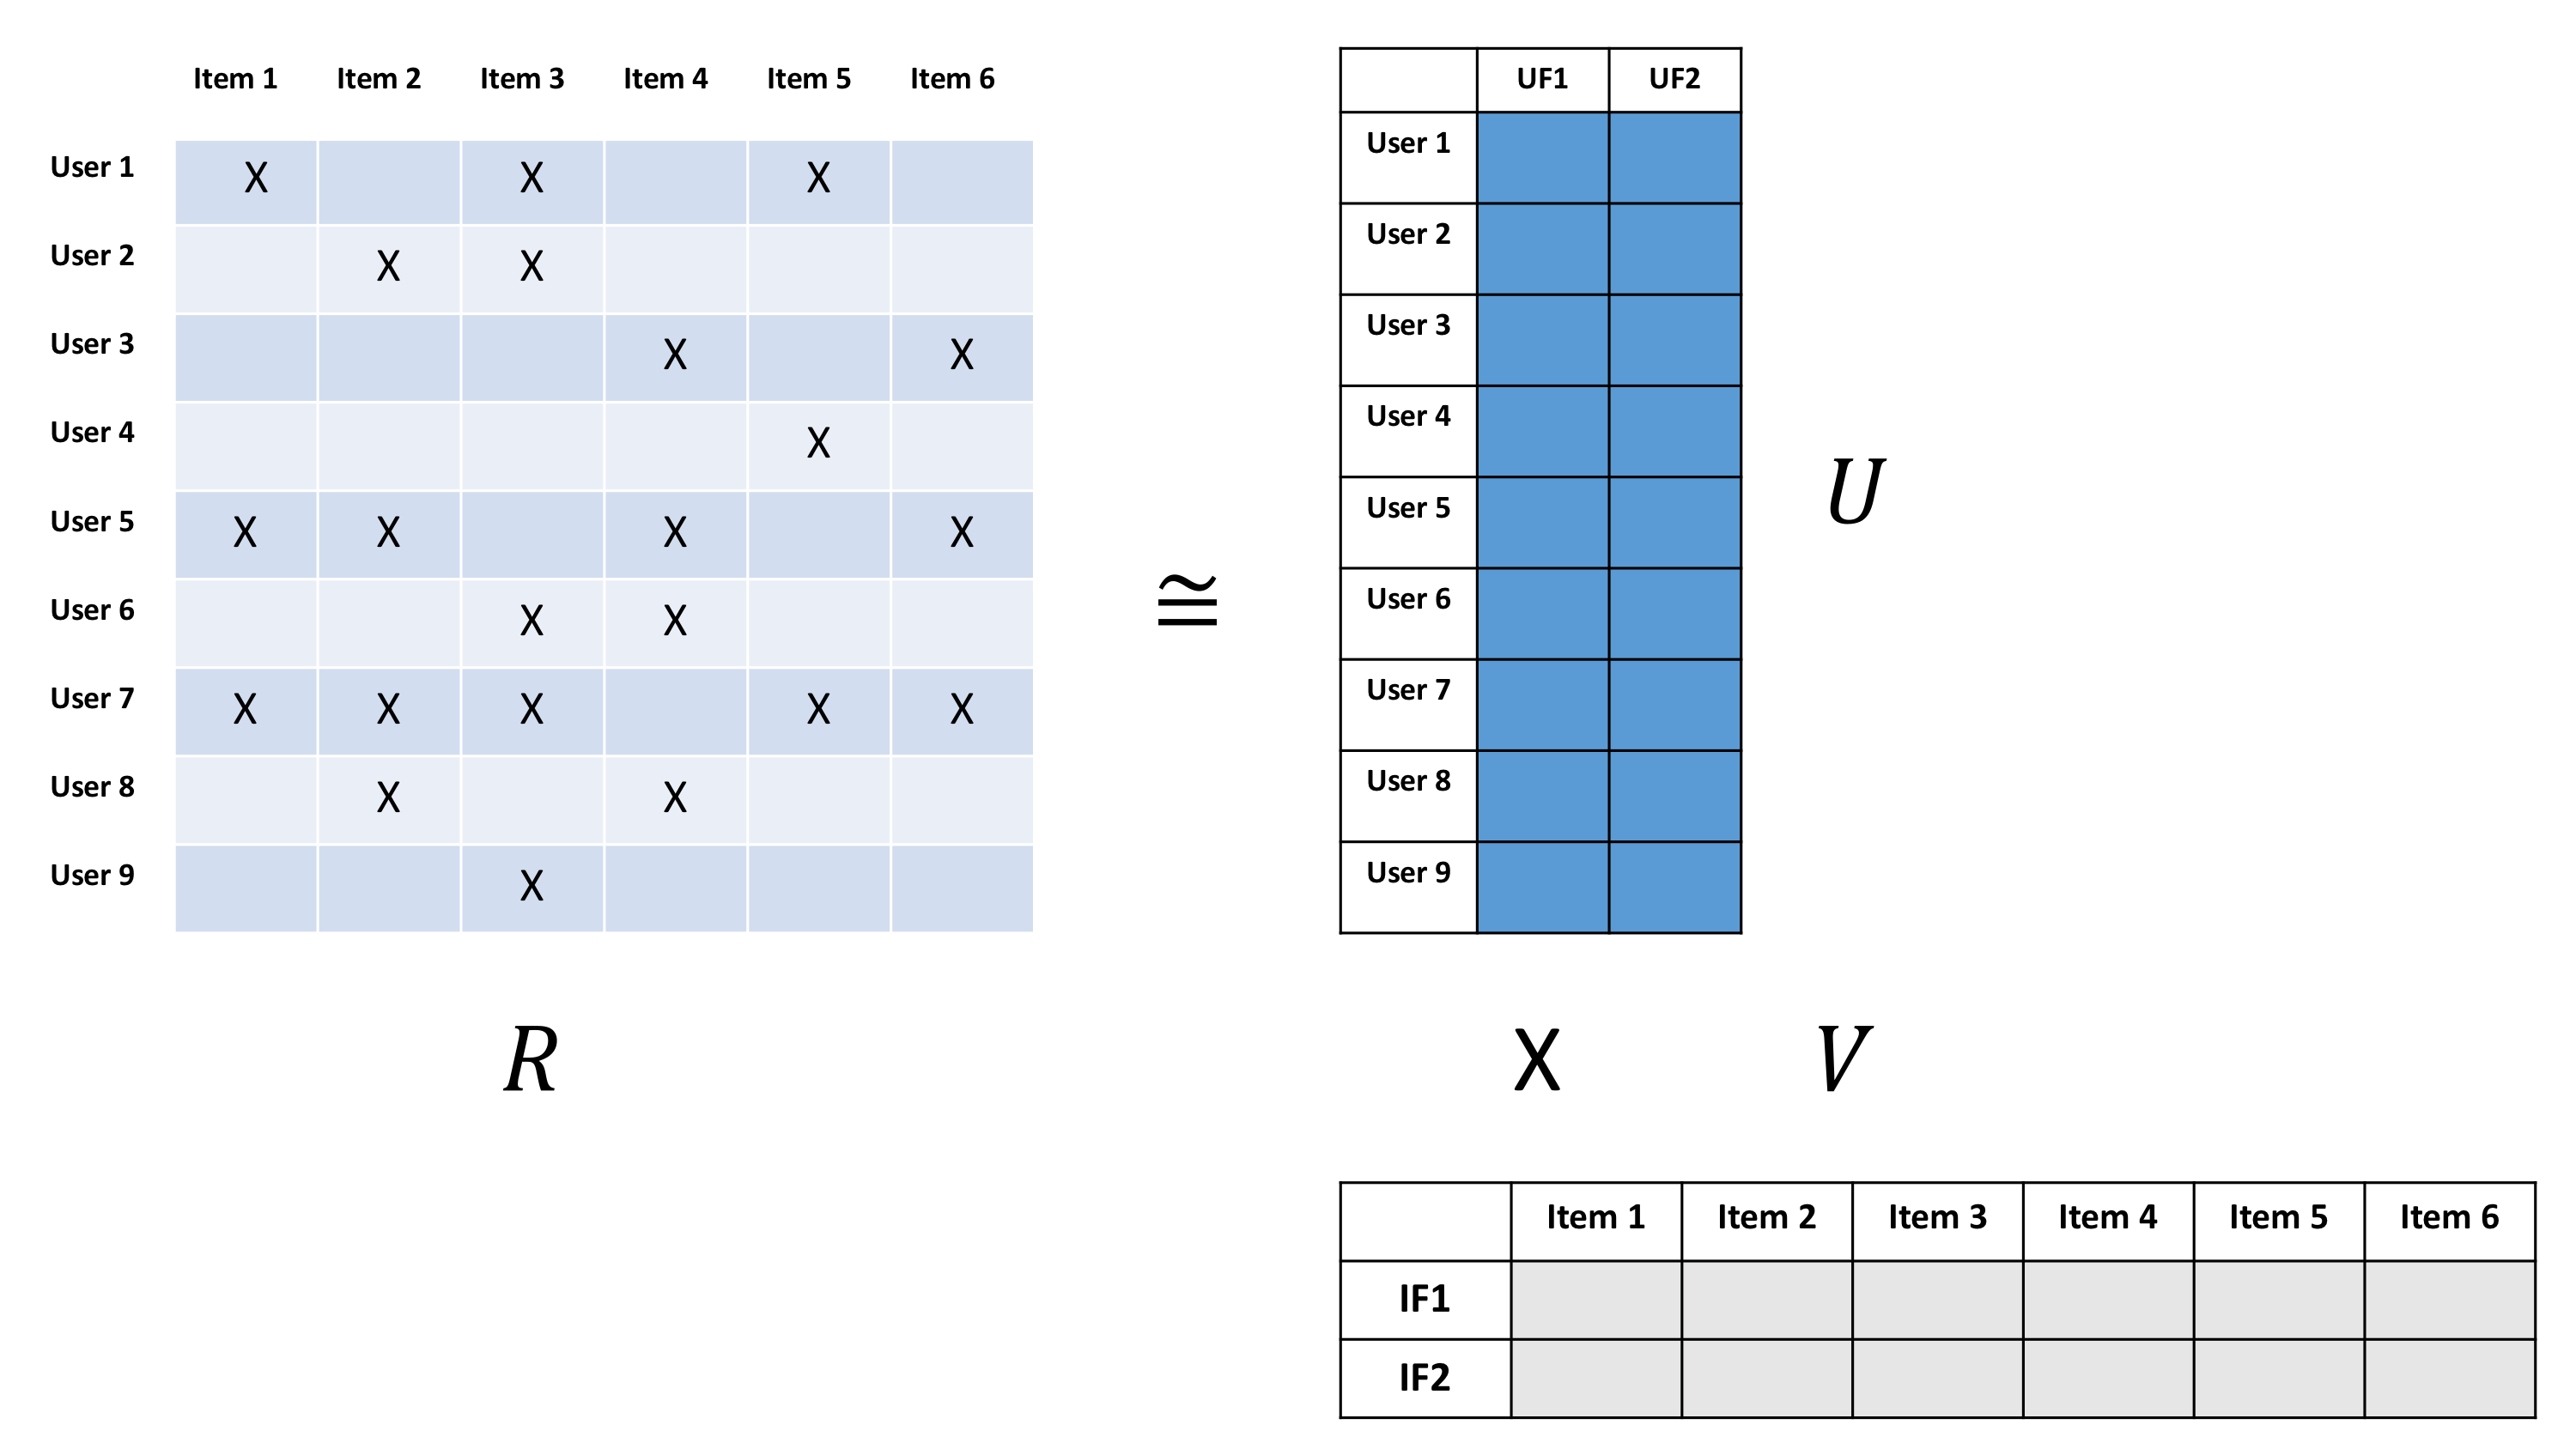

In order to solve for U and V, we could either utilize SVD (which would require inverting a potentially very large matrix and be computationally expensive) to solve the factorization more precisely or apply ALS to approximate it. In the case of ALS, we only need to solve one feature vector at a time, which means it can be run in parallel! (This large advantage is probably why it is the method of choice for Spark). To do this, we can randomly initialize U and solve for V. Then we can go back and solve for U using our solution for V. Keep iterating back and forth like this until we get a convergence that approximates R as best as we can.

After this has been finished, we can simply take the dot product of U and V to see what the predicted rating would be for a specific user/item interaction, even if there was no prior interaction. This basic methodology was adopted for implicit feedback problems in the paper Collaborative Filtering for Implicit Feedback Datasets by Hu, Koren, and Volinsky. We will use this paper's method on a real dataset and build our own recommender system.

### **Entrenamiento con ALS Conjugado**

* Factores Latentes (factors) = 50, 100, 200
* Regularización = 0.01, 0.1

**class** implicit.als.AlternatingLeastSquares(factors=100, regularization=0.01, dtype=<type 'numpy.float32'>, use_native=True, use_cg=True, use_gpu=False, iterations=15, calculate_training_loss=False, num_threads=0, random_state=None)

## Realización de los experimentos en diferentes hiperpametros

* Factores Latentes (factors) = 50
* Regularización = 0.01

Código extraido de http://ethen8181.github.io/machine-learning/recsys/2_implicit.html

In [ ]:
class ALSWR:
    """
    Alternating Least Squares with Weighted Regularization
    for implicit feedback

    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm

    n_factors : int
        number/dimension of user and item latent factors

    alpha : int
        scaling factor that indicates the level of confidence in preference

    reg : int
        regularization term for the user and item latent factors

    seed : int
        seed for the randomly initialized user, item latent factors

    Reference
    ---------
    Y. Hu, Y. Koren, C. Volinsky Collaborative Filtering for Implicit Feedback Datasets
    http://yifanhu.net/PUB/cf.pdf
    """
    def __init__(self, n_iters, n_factors, alpha, reg, seed):
        self.reg = reg
        self.seed = seed
        self.alpha = alpha
        self.n_iters = n_iters
        self.n_factors = n_factors
    
    def fit(self, ratings):
        """
        ratings : scipy sparse csr_matrix [n_users, n_items]
            sparse matrix of user-item interactions
        """        
        # the original confidence vectors should include a + 1,
        # but this direct addition is not allowed when using sparse matrix,
        # thus we'll have to deal with this later in the computation
        Cui = ratings.copy().tocsr()
        Cui.data *= self.alpha
        Ciu = Cui.T.tocsr()
        self.n_users, self.n_items = Cui.shape
        
        # initialize user latent factors and item latent factors
        # randomly with a specified set seed
        rstate = np.random.RandomState(self.seed)
        self.user_factors = rstate.normal(size = (self.n_users, self.n_factors))
        self.item_factors = rstate.normal(size = (self.n_items, self.n_factors))
        
        for _ in trange(self.n_iters, desc = 'training progress'):
            self._als_step(Cui, self.user_factors, self.item_factors)
            self._als_step(Ciu, self.item_factors, self.user_factors)  
        
        return self
    
    def _als_step(self, Cui, X, Y):
        """
        when solving the user latent vectors,
        the item vectors will be fixed and vice versa
        """
        # the variable name follows the notation when holding
        # the item vector Y constant and solving for user vector X
        
        # YtY is a d * d matrix that is computed
        # independently of each user
        YtY = Y.T.dot(Y)
        data = Cui.data
        indptr, indices = Cui.indptr, Cui.indices

        # for every user build up A and b then solve for Ax = b,
        # this for loop is the bottleneck and can be easily parallized
        # as each users' computation is independent of one another
        for u in range(self.n_users):
            # initialize a new A and b for every user
            b = np.zeros(self.n_factors)
            A = YtY + self.reg * np.eye(self.n_factors)
            
            for index in range(indptr[u], indptr[u + 1]):
                # indices[index] stores non-zero positions for a given row
                # data[index] stores corresponding confidence,
                # we also add 1 to the confidence, since we did not 
                # do it in the beginning, when we were to give every 
                # user-item pair and minimal confidence
                i = indices[index]
                confidence = data[index] + 1
                factor = Y[i]

                # for b, Y^T C^u p_u
                # there should be a times 1 for the preference 
                # Pui = 1
                # b += confidence * Y[i] * Pui
                # but the times 1 can be dropped
                b += confidence * factor
                
                # for A, Y^T (C^u - I) Y
                A += (confidence - 1) * np.outer(factor, factor)

            X[u] = np.linalg.solve(A, b)
        
        return self

    def predict(self):
        """predict ratings for every user and item"""
        prediction = self.user_factors.dot(self.item_factors.T)
        return prediction
    
    def _predict_user(self, user):
        """
        returns the predicted ratings for the specified user,
        this is mainly used in computing evaluation metric
        """
        user_pred = self.user_factors[user].dot(self.item_factors.T)
        return user_pred

In [ ]:
als = ALSWR(n_iters = 15, n_factors = 20, alpha = 15, reg = 0.01, seed = 1234)
als.fit(X_train)

training progress: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


# **Simulaciones de ALS**

* Factores Latentes (factors) = 50
* Regularización = 0.1

In [ ]:
@count_elapsed_time
def test():

  # Definimos y entrenamos el modelo con optimización ALS
  factors=50
  regularization=0.1

  model_als1 = implicit.als.AlternatingLeastSquares(factors,regularization,use_gpu=False, num_threads=1)
  model_als1.fit(X_train)

test()


Elapsed time: 11.3709037304 seconds.


In [ ]:
factors=50
regularization=0.1

model_als1 = implicit.als.AlternatingLeastSquares(factors,regularization,use_gpu=False, num_threads=1)
model_als1.fit(X_train)

* Factores Latentes (factors) = 50
* Regularización = 0.01

In [ ]:
@count_elapsed_time
def test():

  # Definimos y entrenamos el modelo con optimización ALS
  factors=50
  regularization=0.01

  model_als2 = implicit.als.AlternatingLeastSquares(factors,regularization,use_gpu=False, num_threads=1)
  model_als2.fit(X_train)

test()


Elapsed time: 11.2631514072 seconds.


In [ ]:
factors=50
regularization=0.01

model_als2 = implicit.als.AlternatingLeastSquares(factors,regularization,use_gpu=False, num_threads=1)
model_als2.fit(X_train)

* Factores Latentes (factors) = 100
* Regularización = 0.1

In [ ]:
@count_elapsed_time
def test():

  # Definimos y entrenamos el modelo con optimización ALS
  factors=100
  regularization=0.1

  model_als3 = implicit.als.AlternatingLeastSquares(factors,regularization,use_gpu=False, num_threads=1)
  model_als3.fit(X_train)

test()


Elapsed time: 13.9055831432 seconds.


In [ ]:
factors=100
regularization=0.1

model_als3 = implicit.als.AlternatingLeastSquares(factors,regularization,use_gpu=False, num_threads=1)
model_als3.fit(X_train)

* Factores Latentes (factors) =  100
* Regularización = 0.01

In [ ]:
@count_elapsed_time
def test():

  # Definimos y entrenamos el modelo con optimización ALS
  factors=100
  regularization=0.01

  model_als4 = implicit.als.AlternatingLeastSquares(factors,regularization,use_gpu=False, num_threads=1)
  model_als4.fit(X_train)

test()


Elapsed time: 13.8989467621 seconds.


In [ ]:
factors=100
regularization=0.01

model_als4 = implicit.als.AlternatingLeastSquares(factors,regularization,use_gpu=False, num_threads=1)
model_als4.fit(X_train)

* Factores Latentes (factors) =  200
* Regularización = 0.1

In [ ]:
@count_elapsed_time
def test():

  # Definimos y entrenamos el modelo con optimización ALS
  factors=200
  regularization=0.1

  model_als5 = implicit.als.AlternatingLeastSquares(factors,regularization,use_gpu=False, num_threads=1)
  model_als5.fit(X_train)

test()


Elapsed time: 23.7926082611 seconds.


In [ ]:
factors=200
regularization=0.1

model_als5 = implicit.als.AlternatingLeastSquares(factors,regularization,use_gpu=False, num_threads=1)
model_als5.fit(X_train)

* Factores Latentes (factors) =  200
* Regularización = 0.01

In [ ]:
@count_elapsed_time
def test():

  # Definimos y entrenamos el modelo con optimización ALS
  factors=200
  regularization=0.01

  model_als6 = implicit.als.AlternatingLeastSquares(factors,regularization,use_gpu=False, num_threads=1)
  model_als6.fit(X_train)

test()


Elapsed time: 23.6185083389 seconds.


In [ ]:
factors=200
regularization=0.01

model_als6 = implicit.als.AlternatingLeastSquares(factors,regularization,use_gpu=False, num_threads=1)
model_als6.fit(X_train)

# **Bayesian Personalized Ranking**

## **BayesianPersonalizedRanking - Implicit**

### **Entrenamiento con optimizacion BPR**

* Factores Latentes (factors) = 50, 100, 200
* Regularización = 0.01, 0.1
* Learning rate = 0.001, 0.01

**class** implicit.bpr.BayesianPersonalizedRanking

* Factores Latentes (factors) = 50
* Regularización = 0.01
* Learning rate = 0.001

In [ ]:
@count_elapsed_time
def test():

  factors=50
  regularization=0.01
  learning_rate=0.001

  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr1 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
  model_bpr1.fit(X_train)

test()


Elapsed time: 2.9155752659 seconds.


In [ ]:
factors=50
regularization=0.01
learning_rate=0.001

# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr1 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
model_bpr1.fit(X_train)

* Array of latent factors for each item in the training set

* Factores Latentes (factors) = 50
* Regularización = 0.01
* Learning rate = 0.01

In [ ]:
@count_elapsed_time
def test():

  factors=50
  regularization=0.01
  learning_rate=0.01

  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr2 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
  model_bpr2.fit(X_train)

test()


Elapsed time: 2.8428256512 seconds.


In [ ]:
factors=50
regularization=0.01
learning_rate=0.01

# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr2 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
model_bpr2.fit(X_train)

* Factores Latentes (factors) = 50
* Regularización = 0.1
* Learning rate = 0.01

In [ ]:
@count_elapsed_time
def test():

  factors=50
  regularization=0.1
  learning_rate=0.01

  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr3 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
  model_bpr3.fit(X_train)

test()


Elapsed time: 2.8489432335 seconds.


In [ ]:
factors=50
regularization=0.1
learning_rate=0.001

# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr3 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
model_bpr3.fit(X_train)

* Factores Latentes (factors) = 50
* Regularización = 0.1
* Learning rate = 0.01

In [ ]:
@count_elapsed_time
def test():

  factors=50
  regularization=0.1
  learning_rate=0.01

  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr4 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
  model_bpr4.fit(X_train)

test()


Elapsed time: 2.7760121822 seconds.


In [ ]:
factors=50
regularization=0.1
learning_rate=0.001

# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr4 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
model_bpr4.fit(X_train)

* Factores Latentes (factors) = 100
* Regularización = 0.01
* Learning rate = 0.001

In [ ]:
@count_elapsed_time
def test():

  factors=100
  regularization=0.01
  learning_rate=0.001

  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr5 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
  model_bpr5.fit(X_train)

test()


Elapsed time: 3.6388626099 seconds.


In [ ]:
factors=100
regularization=0.01
learning_rate=0.001

# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr5 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
model_bpr5.fit(X_train)

* Factores Latentes (factors) = 100
* Regularización = 0.01
* Learning rate = 0.01

In [ ]:
@count_elapsed_time
def test():

  factors=100
  regularization=0.01
  learning_rate=0.01

  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr6 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
  model_bpr6.fit(X_train)

test()


Elapsed time: 3.6991169453 seconds.


In [ ]:
factors=100
regularization=0.01
learning_rate=0.01

# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr6 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
model_bpr6.fit(X_train)

* Factores Latentes (factors) = 100
* Regularización = 0.1
* Learning rate = 0.001

In [ ]:
@count_elapsed_time
def test():

  factors=100
  regularization=0.1
  learning_rate=0.001

  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr7 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
  model_bpr7.fit(X_train)

test()


Elapsed time: 3.5153992176 seconds.


In [ ]:
factors=100
regularization=0.1
learning_rate=0.001

# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr7 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
model_bpr7.fit(X_train)

* Factores Latentes (factors) = 100
* Regularización = 0.1
* Learning rate = 0.01

In [ ]:
@count_elapsed_time
def test():

  factors=100
  regularization=0.1
  learning_rate=0.01

  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr8 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
  model_bpr8.fit(X_train)

test()


Elapsed time: 3.5482349396 seconds.


In [ ]:
factors=100
regularization=0.1
learning_rate=0.01

# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr8 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
model_bpr8.fit(X_train)

* Factores Latentes (factors) = 200
* Regularización = 0.01
* Learning rate = 0.001

In [ ]:
@count_elapsed_time
def test():

  factors=200
  regularization=0.01
  learning_rate=0.001

  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr9 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
  model_bpr9.fit(X_train)

test()


Elapsed time: 5.0914733410 seconds.


In [ ]:
factors=200
regularization=0.01
learning_rate=0.001

# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr9 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
model_bpr9.fit(X_train)

* Factores Latentes (factors) = 200
* Regularización = 0.01
* Learning rate = 0.01

In [ ]:
@count_elapsed_time
def test():

  factors=200
  regularization=0.01
  learning_rate=0.01

  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr10 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
  model_bpr10.fit(X_train)

test()


Elapsed time: 5.0650684834 seconds.


In [ ]:
factors=200
regularization=0.01
learning_rate=0.01

# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr10 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
model_bpr10.fit(X_train)

* Factores Latentes (factors) = 200
* Regularización = 0.1
* Learning rate = 0.001

In [ ]:
@count_elapsed_time
def test():

  factors=200
  regularization=0.1
  learning_rate=0.001

  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr11 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
  model_bpr11.fit(X_train)

test()


Elapsed time: 4.9426422119 seconds.


In [ ]:
factors=200
regularization=0.1
learning_rate=0.001

# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr11 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
model_bpr11.fit(X_train)

* Factores Latentes (factors) = 200
* Regularización = 0.1
* Learning rate = 0.01

In [ ]:
@count_elapsed_time
def test():

  factors=200
  regularization=0.1
  learning_rate=0.01

  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr12 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
  model_bpr12.fit(X_train)

test()


Elapsed time: 4.8526723385 seconds.


In [ ]:
factors=200
regularization=0.1
learning_rate=0.01

# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr12 = implicit.bpr.BayesianPersonalizedRanking(factors,regularization,learning_rate,use_gpu=False, num_threads=1)
model_bpr12.fit(X_train)

### **Métricas**

In [ ]:
def compute_apk(y_true, y_pred, k):
    """
    average precision at k, y_pred is assumed 
    to be truncated to length k prior to feeding
    it to the function
    """
    # convert to set since membership 
    # testing in a set is vastly faster
    actual = set(y_true)
    
    # precision at i is a percentage of correct 
    # items among first i recommendations; the
    # correct count will be summed up by n_hit
    n_hit = 0
    precision = 0
    for i, p in enumerate(y_pred, 1):
        if p in actual:
            n_hit += 1
            precision += n_hit / i

    # divide by recall at the very end
    avg_precision = precision / min(len(actual), k)
    return avg_precision

In [ ]:
def mapk_score(model, ratings, k):
  item_factors=model.item_factors
  user_factors=model.user_factors

  mapk = 0
  n_users = ratings.shape[0]
  for u in range(n_users):
    y_true = ratings[u].indices
    u_pred = model.user_factors[u].dot(model.item_factors.T)
    y_pred = np.argsort(u_pred)[::-1][:k]
    mapk += compute_apk(y_true, y_pred, k)


  mapk /= n_users
  return mapk

In [ ]:
def dcg_at_k(score, k = None):
    """
    discounted cumulative gain (dcg)
    
    Parameters
    ----------
    score : 1d nd.array
        ranking/relevance score
        
    k : int, default None
        evaluate the measure for the top-k ranking score,
        default None evaluates all
        
    Returns
    -------
    dcg: float
    """
    if k is not None:
        score = score[:k]

    gain = 2 ** score - 1
    discounts = np.log2(np.arange(2, score.size + 2))
    dcg = np.sum(gain / discounts)
    return dcg


#score = np.array([2, 0, 3, 2])
#dcg_at_k(score)

In [ ]:
def ndcg_at_k(score, k = None):
    """
    normalized discounted cumulative gain (ndcg)
    
    Parameters
    ----------
    score : 1d nd.array
        ranking/relevance score
        
    k : int, default None
        evaluate the measure for the top-k ranking score,
        default None evaluates all
        
    Returns
    -------
    ndcg: float, 0.0 ~ 1.0
    """
    actual_dcg = dcg_at_k(score, k)
    sorted_score = np.sort(score)[::-1]
    best_dcg = dcg_at_k(sorted_score, k)
    ndcg = actual_dcg / best_dcg
    return ndcg


#ndcg_at_k(score)

In [ ]:
def ndcg_score(model, ratings, k):
    """
    Normalized discounted cumulative gain (NDCG) at rank k
    for the ALS model; which computes the ndcg score for
    each users' recommendation and does a simply average
    
    Parameters
    ----------
    model : ALSWR instance
        fitted ALSWR model

    ratings : scipy sparse csr_matrix [n_users, n_items]
        sparse matrix of user-item interactions

    k : int
        rank k's k
        
    Returns
    -------
    avg_ndcg : float
        ndcg at k's score averaged across all users
    """
    ndcg = 0.0
    n_users, n_items = ratings.shape
    for u in range(n_users):
        y_true = np.zeros(n_items)
        y_true[ratings[u].indices] = 1
        u_pred = model.user_factors[u].dot(model.item_factors.T)
        ndcg += ndcg_at_k(y_true, u_pred, k)
        
    avg_ndcg = ndcg / n_users
    return avg_ndcg


def ndcg_at_k(y_true, y_score, k = 10):
    """
    Normalized discounted cumulative gain (NDCG) at rank k
    
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)
    
    y_score : array-like, shape = [n_samples]
        Predicted scores
    
    k : int
        Rank

    Returns
    -------
    ndcg : float, 0.0 ~ 1.0
    """
    actual = dcg_at_k(y_true, y_score, k)
    best = dcg_at_k(y_true, y_true, k) 
    ndcg = actual / best
    return ndcg


def dcg_at_k(y_true, y_score, k = 10):
    """
    Discounted cumulative gain (DCG) at rank k
    
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)
    
    y_score : array-like, shape = [n_samples]
        Predicted scores
    
    k : int
        Rank

    Returns
    -------
    dcg : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, gains.size + 2))
    dcg = np.sum(gains / discounts)
    return dcg

In [ ]:
k = 20

In [ ]:
mapk_train1 = mapk_score(model_als1, X_train, k)
mapk_test1 = mapk_score(model_als1, X_test, k)
print('mapk training:', mapk_train1)
print('mapk testing:', mapk_test1)

mapk training: 0.0001353687208622403
mapk testing: 3.2005920936351866e-05


In [ ]:
ndcg_train1 = ndcg_score(model_als1, X_train, k)
ndcg_test1 = ndcg_score(model_als1, X_test, k)
print('ndcg training:', ndcg_train1)
print('ndcg testing:', ndcg_test1)

ndcg training: 0.0006428442110874949
ndcg testing: 0.0002003068326054984


In [ ]:
mapk_train2 = mapk_score(model_als2, X_train, k)
mapk_test2 = mapk_score(model_als2, X_test, k)
print('mapk training:', mapk_train2)
print('mapk testing:', mapk_test2)

mapk training: 0.00011186075022343993
mapk testing: 9.353379571672062e-05


In [ ]:
ndcg_train2 = ndcg_score(model_als2, X_train, k)
ndcg_test2 = ndcg_score(model_als2, X_test, k)
print('ndcg training:', ndcg_train2)
print('ndcg testing:', ndcg_test2)

ndcg training: 0.0006262994344093279
ndcg testing: 0.0002993524849479761


In [ ]:
mapk_train3 = mapk_score(model_als3, X_train, k)
mapk_test3 = mapk_score(model_als3, X_test, k)
print('mapk training:', mapk_train3)
print('mapk testing:', mapk_test3)

mapk training: 9.07982988131432e-05
mapk testing: 2.9131106396386577e-05


In [ ]:
ndcg_train3 = ndcg_score(model_als3, X_train, k)
ndcg_test3 = ndcg_score(model_als3, X_test, k)
print('ndcg training:', ndcg_train3)
print('ndcg testing:', ndcg_test3)

ndcg training: 0.0004480254296676966
ndcg testing: 0.00021462439971286994


In [ ]:
mapk_train4 = mapk_score(model_als4, X_train, k)
mapk_test4 = mapk_score(model_als4, X_test, k)
print('mapk training:', mapk_train4)
print('mapk testing:', mapk_test4)

mapk training: 8.680859181622973e-05
mapk testing: 2.374380386178326e-05


In [ ]:
ndcg_train4 = ndcg_score(model_als4, X_train, k)
ndcg_test4 = ndcg_score(model_als4, X_test, k)
print('ndcg training:', ndcg_train4)
print('ndcg testing:', ndcg_test4)

ndcg training: 0.00045688312177086086
ndcg testing: 0.00017265315101539714


In [ ]:
mapk_train5 = mapk_score(model_als5, X_train, k)
mapk_test5 = mapk_score(model_als5, X_test, k)
print('mapk training:', mapk_train5)
print('mapk testing:', mapk_test5)

mapk training: 6.956035135385971e-05
mapk testing: 3.336876821361639e-05


In [ ]:
ndcg_train5 = ndcg_score(model_als5, X_train, k)
ndcg_test5 = ndcg_score(model_als5, X_test, k)
print('ndcg training:', ndcg_train5)
print('ndcg testing:', ndcg_test5)

ndcg training: 0.00047626678442593066
ndcg testing: 0.00022338020581878757


In [ ]:
mapk_train6 = mapk_score(model_als6, X_train, k)
mapk_test6 = mapk_score(model_als6, X_test, k)
print('mapk training:', mapk_train6)
print('mapk testing:', mapk_test6)

mapk training: 8.313092991440988e-05
mapk testing: 3.6295396122348014e-05


In [ ]:
ndcg_train = ndcg_score(model_als1, X_train, k)
ndcg_test = ndcg_score(model_als1, X_test, k)
print('ndcg training:', ndcg_train)
print('ndcg testing:', ndcg_test)

ndcg training: 0.0006428442110874949
ndcg testing: 0.0002003068326054984


# **BPR**

In [ ]:
k = 20

In [ ]:
mapk_train01 = mapk_score(model_bpr1, X_train, k)
mapk_test01 = mapk_score(model_bpr1, X_test, k)
print('mapk training:', mapk_train01)
print('mapk testing:', mapk_test01)

mapk training: 0.00010996744168654689
mapk testing: 5.73563743530966e-05


In [ ]:
ndcg_train01 = ndcg_score(model_bpr1, X_train, k)
ndcg_test01 = ndcg_score(model_bpr1, X_test, k)
print('ndcg training:', ndcg_train01)
print('ndcg testing:', ndcg_test01)

ndcg training: 0.0005691207588908935
ndcg testing: 0.00020593615912693557


In [ ]:
mapk_train02 = mapk_score(model_bpr2, X_train, k)
mapk_test02 = mapk_score(model_bpr2, X_test, k)
print('mapk training:', mapk_train02)
print('mapk testing:', mapk_test02)

mapk training: 9.675773536967731e-05
mapk testing: 5.27146007371996e-05


In [ ]:
ndcg_train02 = ndcg_score(model_bpr2, X_train, k)
ndcg_test02 = ndcg_score(model_bpr2, X_test, k)
print('ndcg training:', ndcg_train02)
print('ndcg testing:', ndcg_test02)

ndcg training: 0.0005341100147037986
ndcg testing: 0.00018209403170697382


In [ ]:
mapk_train03 = mapk_score(model_bpr3, X_train, k)
mapk_test03 = mapk_score(model_bpr3, X_test, k)
print('mapk training:', mapk_train03)
print('mapk testing:', mapk_test03)

mapk training: 7.796499204220484e-05
mapk testing: 2.3465891140644658e-05


In [ ]:
ndcg_train03 = ndcg_score(model_bpr3, X_train, k)
ndcg_test03 = ndcg_score(model_bpr3, X_test, k)
print('ndcg training:', ndcg_train03)
print('ndcg testing:', ndcg_test03)

ndcg training: 0.0005207788841954218
ndcg testing: 0.00012107587114578008


In [ ]:
mapk_train04 = mapk_score(model_bpr4, X_train, k)
mapk_test04 = mapk_score(model_bpr4, X_test, k)
print('mapk training:', mapk_train04)
print('mapk testing:', mapk_test04)

mapk training: 7.526303075692918e-05
mapk testing: 2.5414833621791696e-06


In [ ]:
ndcg_train04 = ndcg_score(model_bpr4, X_train, k)
ndcg_test04 = ndcg_score(model_bpr4, X_test, k)
print('ndcg training:', ndcg_train04)
print('ndcg testing:', ndcg_test04)

ndcg training: 0.0005686643418662065
ndcg testing: 2.4201823496823315e-05


In [ ]:
mapk_train05 = mapk_score(model_bpr5, X_train, k)
mapk_test05 = mapk_score(model_bpr5, X_test, k)
print('mapk training:', mapk_train05)
print('mapk testing:', mapk_test05)

mapk training: 0.00010521963655618249
mapk testing: 2.9448134580315316e-05


In [ ]:
ndcg_train05 = ndcg_score(model_bpr5, X_train, k)
ndcg_test05 = ndcg_score(model_bpr5, X_test, k)
print('ndcg training:', ndcg_train05)
print('ndcg testing:', ndcg_test05)

ndcg training: 0.0005425586956622321
ndcg testing: 0.00018790528884201057


In [ ]:
mapk_train06 = mapk_score(model_bpr6, X_train, k)
mapk_test06 = mapk_score(model_bpr6, X_test, k)
print('mapk training:', mapk_train06)
print('mapk testing:', mapk_test06)

mapk training: 0.00011728933111390677
mapk testing: 9.828352577881768e-06


In [ ]:
ndcg_train06 = ndcg_score(model_bpr6, X_train, k)
ndcg_test06 = ndcg_score(model_bpr6, X_test, k)
print('ndcg training:', ndcg_train06)
print('ndcg testing:', ndcg_test06)

ndcg training: 0.0006595591653678763
ndcg testing: 6.177174453846852e-05


In [ ]:
mapk_train07 = mapk_score(model_bpr7, X_train, k)
mapk_test07 = mapk_score(model_bpr7, X_test, k)
print('mapk training:', mapk_train07)
print('mapk testing:', mapk_test07)

mapk training: 7.077548392929734e-05
mapk testing: 2.1485085736775117e-05


In [ ]:
ndcg_train07 = ndcg_score(model_bpr7, X_train, k)
ndcg_test07 = ndcg_score(model_bpr7, X_test, k)
print('ndcg training:', ndcg_train07)
print('ndcg testing:', ndcg_test07)

ndcg training: 0.0005331968594687677
ndcg testing: 0.00014719616034274263


In [ ]:
mapk_train08 = mapk_score(model_bpr8, X_train, k)
mapk_test08 = mapk_score(model_bpr8, X_test, k)
print('mapk training:', mapk_train08)
print('mapk testing:', mapk_test08)

mapk training: 9.242288666443105e-05
mapk testing: 0.00012433768344399026


In [ ]:
ndcg_train08 = ndcg_score(model_bpr8, X_train, k)
ndcg_test08 = ndcg_score(model_bpr8, X_test, k)
print('ndcg training:', ndcg_train08)
print('ndcg testing:', ndcg_test08)

ndcg training: 0.00047763993402773577
ndcg testing: 0.00040361698018568146


In [ ]:
mapk_train09 = mapk_score(model_bpr9, X_train, k)
mapk_test09 = mapk_score(model_bpr9, X_test, k)
print('mapk training:', mapk_train09)
print('mapk testing:', mapk_test09)

mapk training: 6.813765392196764e-05
mapk testing: 5.611143872286371e-05


In [ ]:
ndcg_train09 = ndcg_score(model_bpr9, X_train, k)
ndcg_test09 = ndcg_score(model_bpr9, X_test, k)
print('ndcg training:', ndcg_train09)
print('ndcg testing:', ndcg_test09)

ndcg training: 0.0004508815193646297
ndcg testing: 0.0002493674008680178


In [ ]:
mapk_train010 = mapk_score(model_bpr10, X_train, k)
mapk_test010 = mapk_score(model_bpr10, X_test, k)
print('mapk training:', mapk_train010)
print('mapk testing:', mapk_test010)

mapk training: 0.00011359984572292094
mapk testing: 2.8696977849520223e-05


In [ ]:
ndcg_train010 = ndcg_score(model_bpr10, X_train, k)
ndcg_test010 = ndcg_score(model_bpr10, X_test, k)
print('ndcg training:', ndcg_train010)
print('ndcg testing:', ndcg_test010)

ndcg training: 0.0006466021375755573
ndcg testing: 0.00010880814879306265


In [ ]:
mapk_train011 = mapk_score(model_bpr11, X_train, k)
mapk_test011 = mapk_score(model_bpr11, X_test, k)
print('mapk training:', mapk_train011)
print('mapk testing:', mapk_test011)

mapk training: 4.227787828739361e-05
mapk testing: 0.0001318278742949176


In [ ]:
ndcg_train011 = ndcg_score(model_bpr11, X_train, k)
ndcg_test011 = ndcg_score(model_bpr11, X_test, k)
print('ndcg training:', ndcg_train011)
print('ndcg testing:', ndcg_test011)

ndcg training: 0.0003662491575230348
ndcg testing: 0.00037665807288062605


In [ ]:
mapk_train012 = mapk_score(model_bpr12, X_train, k)
mapk_test012 = mapk_score(model_bpr12, X_test, k)
print('mapk training:', mapk_train012)
print('mapk testing:', mapk_test012)

mapk training: 7.964003958841083e-05
mapk testing: 5.548263552030031e-05


In [ ]:
ndcg_train012 = ndcg_score(model_bpr12, X_train, k)
ndcg_test012 = ndcg_score(model_bpr12, X_test, k)
print('ndcg training:', ndcg_train012)
print('ndcg testing:', ndcg_test012)

ndcg training: 0.0005704457681144333
ndcg testing: 0.0001531730738036554


Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

**recommend()**

Recommends items for a user

Calculates the N best recommendations for a user, and returns a list of itemids, score.

Parameters:	
* **userid** (int) – The userid to calculate recommendations for
* **user_items** (csr_matrix) – A sparse matrix of shape (number_users, number_items). This lets us look up the liked items and their weights for the  user. This is used to filter out items that have already been liked from the output, and to also potentially calculate the best items for this user.
* **N** (int, optional) – The number of results to return
* **filter_already_liked_items** (bool, optional) – When true, don’t return items present in the training set that were rated by the specificed user.
* **filter_items** (sequence of ints, optional) – List of extra item ids to filter out from the output
* **recalculate_user** (bool, optional) – When true, don’t rely on stored user state and instead recalculate from the passed in user_items

## Creación de Código para pasar a *.JSON

In [ ]:
# Primero creamos el dataframe con los datos
url = '/content/drive/My Drive/Tarea_SR/data/train.csv'
df_train = pd.read_csv(url  ,
                         sep=',',
                        index_col=None,
                         names=['user_id', 'item_id', 'timestamp'],
                         header=0
                  )

print('data dimension: \n', df.shape)
#df.head()

data dimension: 
 (78023, 4)


In [ ]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[0] not in user_items:
        user_items[row[0]] = []
        
    user_items[row[0]].append(row[2])
    itemset.add(row[2])
  

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [ ]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['item_id']

In [ ]:
show_recommendations(model_bpr3, 10, 20)

In [ ]:
def crear_fila(model, item, m):
  a=show_recommendations(model, user=int(item), n=m).array 
  data = list() 
  for x in range(len(a)):
    data.insert(x,a[x])
  return data

## Carga de Datos para las recomendaciones

In [ ]:
# Cargamos el dataset con los items
user_items_test = pd.read_csv('/content/drive/My Drive/Tarea_SR/data/test_users.csv',
                        sep=';',
                        names = ['user_id'],
                        header=None 
                        )

In [ ]:
#df_items.head()

## Generación de archivos *.JSON

In [ ]:
data = {}
#adj = ["1","2","3","4"]
adj=crear_fila1(pruebam)
m=20
model = model_bpr_200_01_001
for x in adj:
    x1=int(x)
    data["user_"+str(x)] = []
    data["user_"+str(x)].append(crear_fila(model,x1, m))



with open('data_model_bpr_200_01_001_20.json', 'w') as outfile:
   json.dump(data, outfile)

# **Gráficos de Resultados Obtenidos**

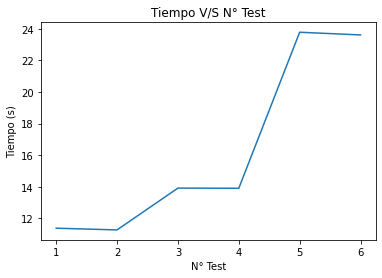

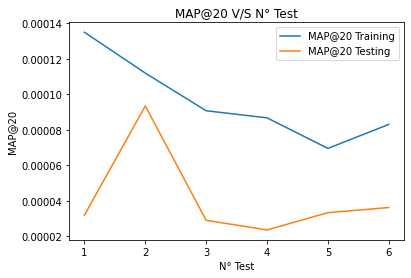

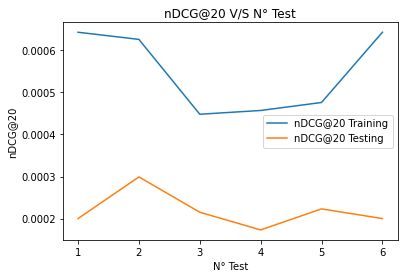

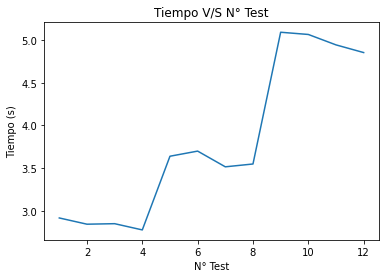

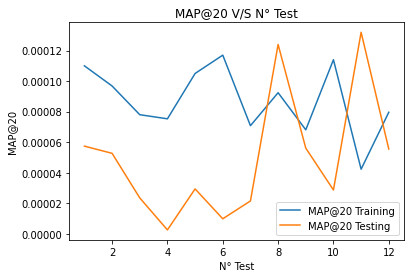

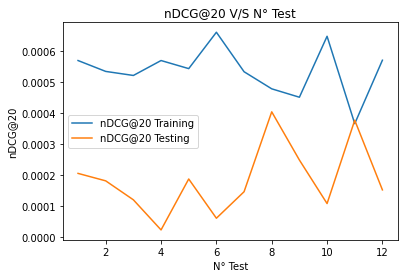

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Tiempo1=  [11.37,11.26,13.91,13.90,23.79,23.62]

MAPTraining1 = [1.35e-04,1.12e-04,9.08e-05,8.68e-05,6.96e-05,8.31e-05]          
MAPTesting1 = [3.20e-05,9.35e-05,2.91e-05,2.37e-05,3.34e-05,3.63e-05]         

nDCGTraining1 = [6.43e-04,6.26e-04,4.48e-04,4.57e-04,4.76e-04,6.43e-04]           
nDCGTesting1 = [2.00e-04,2.99e-04,2.15e-04,1.73e-04,2.23e-04,2.00e-04]

N=[1,2,3,4,5,6]

plt.plot(N, Tiempo1)
plt.xlabel("N° Test")
plt.ylabel("Tiempo (s)")
plt.title("Tiempo V/S N° Test")

plt.show()

plt.plot(N, MAPTraining1)
plt.plot(N, MAPTesting1)
plt.xlabel("N° Test")
plt.ylabel("MAP@20")
plt.title("MAP@20 V/S N° Test")
plt.legend( ('MAP@20 Training', 'MAP@20 Testing'), loc = 'upper right')
plt.show()

plt.plot(N, nDCGTraining1)
plt.plot(N, nDCGTesting1)
plt.xlabel("N° Test")
plt.ylabel("nDCG@20")
plt.title("nDCG@20 V/S N° Test")
plt.legend( ('nDCG@20 Training', 'nDCG@20 Testing'), loc = 'center right')
plt.show()



import numpy as np
import matplotlib.pyplot as plt

Tiempo1=  [2.916,2.843,2.849,2.776,3.639,3.699,3.515,3.548,5.091,5.065,4.943,4.853]

MAPTraining1 = [1.10e-04,9.68e-05,7.80e-05,7.53e-05,1.05e-04,1.17e-04,7.08e-05,9.24e-05,6.81e-05,1.14e-04,4.23e-05,7.96e-05]          
MAPTesting1 = [5.74e-05,5.27e-05,2.35e-05,2.54e-06,2.94e-05,9.83e-06,2.15e-05,1.24e-04,5.61e-05,2.87e-05,1.32e-04,5.55e-05]         

nDCGTraining1 = [5.69e-04,5.34e-04,5.21e-04,5.69e-04,5.43e-04,6.60e-04,5.33e-04,4.78e-04,4.51e-04,6.47e-04,3.66e-04,5.70e-04]           
nDCGTesting1 = [2.06e-04,1.82e-04,1.21e-04,2.42e-05,1.88e-04,6.18e-05,1.47e-04,4.04e-04,2.49e-04,1.09e-04,3.77e-04,1.53e-04]

N=[1,2,3,4,5,6,7,8,9,10,11,12]


plt.plot(N, Tiempo1)
plt.xlabel("N° Test")
plt.ylabel("Tiempo (s)")
plt.title("Tiempo V/S N° Test")

plt.show()

plt.plot(N, MAPTraining1)
plt.plot(N, MAPTesting1)
plt.xlabel("N° Test")
plt.ylabel("MAP@20")
plt.title("MAP@20 V/S N° Test")
plt.legend( ('MAP@20 Training', 'MAP@20 Testing'), loc = 'lower right')
plt.show()

plt.plot(N, nDCGTraining1)
plt.plot(N, nDCGTesting1)
plt.xlabel("N° Test")
plt.ylabel("nDCG@20")
plt.title("nDCG@20 V/S N° Test")
plt.legend( ('nDCG@20 Training', 'nDCG@20 Testing'), loc = 'center left')
plt.show()
